**LSTM**

In [3]:
!pip install numpy pandas matplotlib scikit-learn tensorflow


In [4]:
!cd /content
!wget https://zenodo.org/record/4656522/files/m4_weekly_dataset.zip
!unzip -o m4_weekly_dataset.zip -d /content/m4_weekly


--2025-12-27 09:14:02--  https://zenodo.org/record/4656522/files/m4_weekly_dataset.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.185.48.75, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4656522/files/m4_weekly_dataset.zip [following]
--2025-12-27 09:14:04--  https://zenodo.org/records/4656522/files/m4_weekly_dataset.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1077913 (1.0M) [application/octet-stream]
Saving to: ‘m4_weekly_dataset.zip’

m4_weekly_dataset.z 100%[===================>]   1.03M  1.01MB/s    in 1.0s    

2025-12-27 09:14:05 (1.01 MB/s) - ‘m4_weekly_dataset.zip’ saved [1077913/1077913]

Archive:  m4_weekly_dataset.zip
  inflating: /content/m4_weekly/m4_weekly_dataset.tsf  


In [5]:
import numpy as np
import pandas as pd

def load_tsf(filepath):
    """
    Load a .tsf file and return a dict of series
    """
    series = {}
    # Specify encoding to handle non-UTF-8 characters in the .tsf file
    with open(filepath, "r", encoding="latin1") as f:
        for line in f:
            line = line.strip()

            # skip metadata and comments
            if not line or line.startswith("@") or line.startswith("#"):
                continue

            parts = line.split(":")
            series_id = parts[0]
            values = parts[-1]

            # ? = missing values
            values = [
                float(v) for v in values.split(",")
                if v != "?"
            ]

            series[series_id] = np.array(values, dtype=np.float32)

    return series

TSF_PATH = "/content/m4_weekly/m4_weekly_dataset.tsf"

# Call the now-corrected load_tsf function
series_dict = load_tsf(TSF_PATH)

print("Total series:", len(series_dict))
print("Example series length:", len(next(iter(series_dict.values()))))

Total series: 359
Example series length: 2192


In [6]:
def make_windows(series, input_len=24, horizon=1):
    X, y = [], []
    for i in range(len(series) - input_len - horizon + 1):
        X.append(series[i:i+input_len])
        y.append(series[i+input_len:i+input_len+horizon])
    return np.array(X), np.array(y)


In [7]:
INPUT_LEN = 24   # standard for M4 weekly
HORIZON   = 1

X_all, y_all = [], []

for s in series_dict.values():
    if len(s) < INPUT_LEN + HORIZON:
        continue

    # 🔹 PER-SERIES NORMALIZATION (CRITICAL)
    mean = s.mean()
    std  = s.std() + 1e-8
    s = (s - mean) / std

    X, y = make_windows(s, INPUT_LEN, HORIZON)
    X_all.append(X)
    y_all.append(y)

X_all = np.vstack(X_all)
y_all = np.vstack(y_all)

print("X shape:", X_all.shape)
print("y shape:", y_all.shape)


X shape: (362963, 24)
y shape: (362963, 1)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# LSTM expects 3D
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(INPUT_LEN, 1)),
    Dense(HORIZON)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse"
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    verbose=1
)


Epoch 1/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0984 - val_loss: 0.0760
Epoch 2/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0682 - val_loss: 0.0732
Epoch 3/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0645 - val_loss: 0.0717
Epoch 4/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0618 - val_loss: 0.0703
Epoch 5/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0592 - val_loss: 0.0692
Epoch 6/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0596 - val_loss: 0.0677
Epoch 7/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0599 - val_loss: 0.0670
Epoch 8/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0567 - val_loss: 0.0665
Epoch 9/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0547 - val_loss: 0.0661
Epoch 10/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0560 - val_loss: 0.0650
Epoch 11/20
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0567 - val_loss: 0.0661
Epoch 12/20
2269/22

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


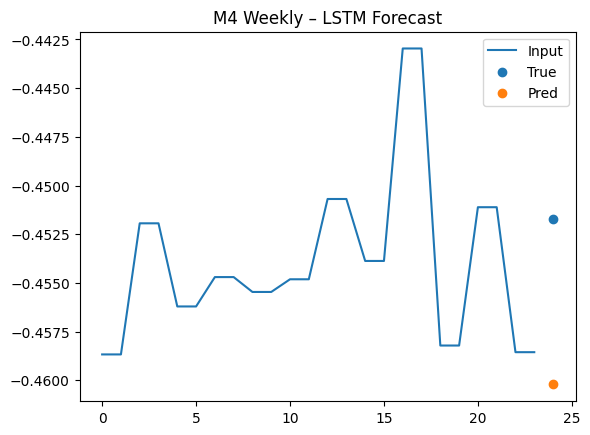

In [11]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(0, len(X_val))

pred = model.predict(X_val[idx:idx+1]).flatten()
true = y_val[idx].flatten()

plt.plot(X_val[idx].flatten(), label="Input")
plt.scatter(len(X_val[idx]), true, label="True")
plt.scatter(len(X_val[idx]), pred, label="Pred")
plt.legend()
plt.title("M4 Weekly – LSTM Forecast")
plt.show()


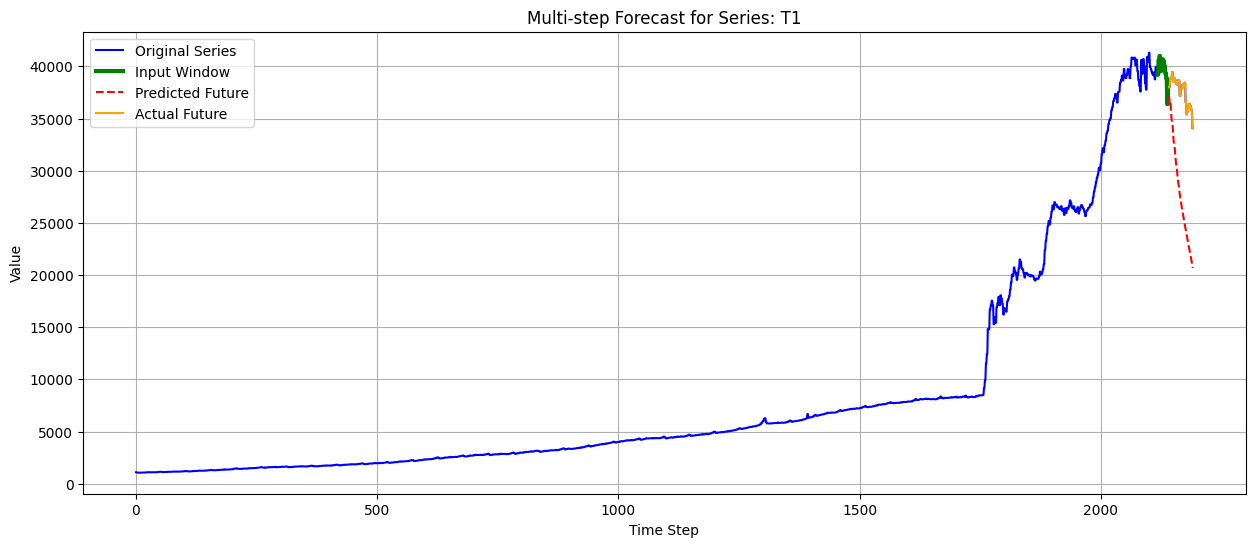

In [12]:
import matplotlib.pyplot as plt

def multi_step_forecast(model, initial_sequence, num_forecast_steps):
    current_sequence = initial_sequence.copy()
    forecasted_steps = []

    for _ in range(num_forecast_steps):
        # Reshape for model input: (1, INPUT_LEN, 1)
        input_for_model = current_sequence[-INPUT_LEN:].reshape(1, INPUT_LEN, 1)
        predicted_value = model.predict(input_for_model, verbose=0)[0, 0] # Get the single predicted value
        forecasted_steps.append(predicted_value)
        # Append the prediction to the sequence for the next step
        current_sequence = np.append(current_sequence, predicted_value)
    return np.array(forecasted_steps)

# Choose a series to visualize (e.g., the first one from the dictionary)
series_id = next(iter(series_dict))
original_series = series_dict[series_id].copy()

# Normalize the chosen series (same as during training)
mean = original_series.mean()
std = original_series.std() + 1e-8
normalized_series = (original_series - mean) / std

# Define the starting point for prediction and the forecast horizon
start_idx = len(normalized_series) - INPUT_LEN - 50 # Choose a point in the series to start forecasting
num_forecast_steps = 50 # How many steps to forecast into the future

# Ensure there's enough data for both input and actual future values
if start_idx < 0:
    print(f"Series {series_id} is too short for chosen start_idx and INPUT_LEN.")
elif start_idx + INPUT_LEN + num_forecast_steps > len(normalized_series):
    print(f"Series {series_id} is too short for chosen forecast horizon. Adjusting forecast steps.")
    num_forecast_steps = len(normalized_series) - (start_idx + INPUT_LEN)
    if num_forecast_steps <= 0:
        print("Not enough data to forecast.")

if num_forecast_steps > 0:
    # Get the initial input sequence for forecasting
    initial_input_sequence = normalized_series[start_idx : start_idx + INPUT_LEN]

    # Perform multi-step forecasting
    predicted_future_normalized = multi_step_forecast(model, initial_input_sequence, num_forecast_steps)

    # Get the actual future values for comparison
    actual_future_normalized = normalized_series[start_idx + INPUT_LEN : start_idx + INPUT_LEN + num_forecast_steps]

    # Denormalize predictions and actual values back to original scale
    predicted_future = (predicted_future_normalized * std) + mean
    actual_future = (actual_future_normalized * std) + mean

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(original_series)), original_series, label='Original Series', color='blue')
    plt.plot(range(start_idx, start_idx + INPUT_LEN), original_series[start_idx : start_idx + INPUT_LEN], label='Input Window', color='green', linewidth=3)
    plt.plot(range(start_idx + INPUT_LEN, start_idx + INPUT_LEN + num_forecast_steps), predicted_future, label='Predicted Future', color='red', linestyle='--')
    plt.plot(range(start_idx + INPUT_LEN, start_idx + INPUT_LEN + num_forecast_steps), actual_future, label='Actual Future', color='orange', linestyle='-')

    plt.title(f'Multi-step Forecast for Series: {series_id}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Could not perform multi-step forecast due to insufficient data.")

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on training data
y_train_pred = model.predict(X_train)

# Calculate training metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

# Predict on validation data
y_val_pred = model.predict(X_val)

# Calculate validation metrics
val_mse = mean_squared_error(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

print(f"Training MSE: {train_mse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"\nValidation MSE: {val_mse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

9075/9075 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Training MSE: 0.0469
Training MAE: 0.0928
Training RMSE: 0.2165

Validation MSE: 0.0621
Validation MAE: 0.0973
Validation RMSE: 0.2492


**NEURAL-ODE**

In [14]:
!pip install torch torchdiffeq numpy scikit-learn matplotlib


In [15]:
import numpy as np

def load_tsf(path):
    series = {}
    with open(path, "r", encoding="latin1") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("@") or line.startswith("#"):
                continue
            parts = line.split(":")
            sid = parts[0]
            values = [float(v) for v in parts[-1].split(",") if v != "?"]
            series[sid] = np.array(values, dtype=np.float32)
    return series

series_dict = load_tsf("/content/m4_weekly/m4_weekly_dataset.tsf")
print("Total series:", len(series_dict))


Total series: 359


In [16]:
def make_windows(series, input_len=24, horizon=6):
    X, y = [], []
    for i in range(len(series) - input_len - horizon + 1):
        X.append(series[i:i+input_len])
        y.append(series[i+input_len:i+input_len+horizon])
    return np.array(X), np.array(y)

INPUT_LEN = 24
HORIZON   = 6

X_all, y_all = [], []

for s in series_dict.values():
    if len(s) < INPUT_LEN + HORIZON:
        continue

    mean = s.mean()
    std  = s.std() + 1e-8
    s = (s - mean) / std

    X, y = make_windows(s, INPUT_LEN, HORIZON)
    X_all.append(X)
    y_all.append(y)

X_all = np.vstack(X_all)
y_all = np.vstack(y_all)

print("X:", X_all.shape, "y:", y_all.shape)


X: (361168, 24) y: (361168, 6)


In [17]:
from sklearn.model_selection import train_test_split
import torch

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train).float().unsqueeze(-1)
y_train = torch.tensor(y_train).float()

X_val = torch.tensor(X_val).float().unsqueeze(-1)
y_val = torch.tensor(y_val).float()


In [18]:
import torch.nn as nn

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, dim)
        )

    def forward(self, t, h):
        return self.net(h)


In [19]:
from torchdiffeq import odeint

class ODERNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn_cell = nn.GRUCell(input_dim, hidden_dim)
        self.odefunc = ODEFunc(hidden_dim)
        self.decoder = nn.Linear(hidden_dim, 1)

    def forward(self, x, horizon):
        batch, seq, _ = x.shape
        h = torch.zeros(batch, self.hidden_dim, device=x.device)

        # Encode history (teacher forcing)
        for t in range(seq):
            h = self.rnn_cell(x[:, t], h)

        # Continuous rollout
        t_span = torch.linspace(0, horizon, horizon + 1, device=x.device)
        h_traj = odeint(self.odefunc, h, t_span, method="rk4")

        preds = self.decoder(h_traj[1:])
        return preds.squeeze(-1)


In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ODERNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
loss_fn = nn.MSELoss()

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)


In [21]:
EPOCHS = 40
BATCH  = 128

for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(len(X_train))
    train_loss = 0

    for i in range(0, len(X_train), BATCH):
        idx = perm[i:i+BATCH]
        xb, yb = X_train[idx], y_train[idx]

        optimizer.zero_grad()
        preds = model(xb, horizon=HORIZON)
        # Transpose preds to match yb shape (BATCH, HORIZON)
        loss = loss_fn(preds.transpose(0, 1), yb)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= (len(X_train) / BATCH)

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val, horizon=HORIZON)
        # Transpose val_preds to match y_val shape (BATCH, HORIZON)
        val_loss = loss_fn(val_preds.transpose(0, 1), y_val).item()

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train MSE: {train_loss:.4f} | "
        f"Val MSE: {val_loss:.4f}"
    )

Epoch 01 | Train MSE: 0.1313 | Val MSE: 0.1213
Epoch 02 | Train MSE: 0.1161 | Val MSE: 0.1151
Epoch 03 | Train MSE: 0.1112 | Val MSE: 0.1103
Epoch 04 | Train MSE: 0.1086 | Val MSE: 0.1084
Epoch 05 | Train MSE: 0.1066 | Val MSE: 0.1068
Epoch 06 | Train MSE: 0.1048 | Val MSE: 0.1052
Epoch 07 | Train MSE: 0.1030 | Val MSE: 0.1031
Epoch 08 | Train MSE: 0.1013 | Val MSE: 0.1018
Epoch 09 | Train MSE: 0.0995 | Val MSE: 0.0996
Epoch 10 | Train MSE: 0.0978 | Val MSE: 0.0976
Epoch 11 | Train MSE: 0.0963 | Val MSE: 0.0973
Epoch 12 | Train MSE: 0.0947 | Val MSE: 0.0954
Epoch 13 | Train MSE: 0.0934 | Val MSE: 0.0939
Epoch 14 | Train MSE: 0.0921 | Val MSE: 0.0935
Epoch 15 | Train MSE: 0.0908 | Val MSE: 0.0925
Epoch 16 | Train MSE: 0.0897 | Val MSE: 0.0907
Epoch 17 | Train MSE: 0.0888 | Val MSE: 0.0915
Epoch 18 | Train MSE: 0.0876 | Val MSE: 0.0895
Epoch 19 | Train MSE: 0.0868 | Val MSE: 0.0875
Epoch 20 | Train MSE: 0.0857 | Val MSE: 0.0887
Epoch 21 | Train MSE: 0.0849 | Val MSE: 0.0868
Epoch 22 | Tr

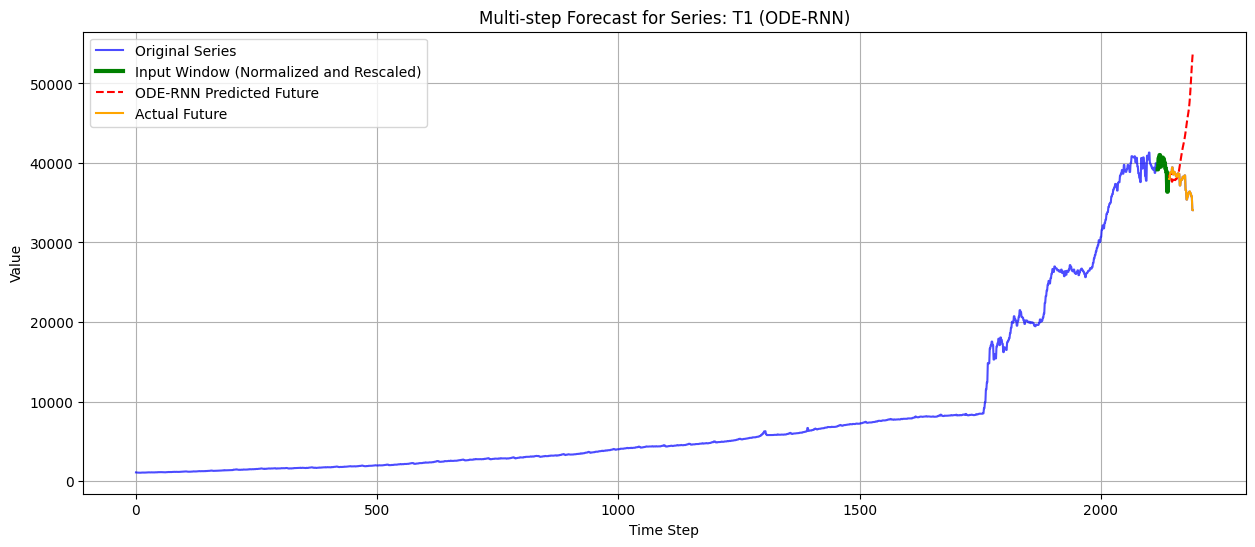

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ensure the model is in evaluation mode
model.eval()

# Choose a series to visualize (e.g., the first one from the dictionary)
series_id = next(iter(series_dict))
original_series = series_dict[series_id].copy()

# Normalize the chosen series (same as during training)
mean = original_series.mean()
std = original_series.std() + 1e-8
normalized_series = (original_series - mean) / std

# Define the starting point for prediction and the forecast horizon
# Make sure the series is long enough to pick a start_idx for input and a horizon for prediction
# Let's try to forecast the last 50 steps if possible, or fewer if the series is shorter.
forecast_horizon_steps = 50
start_idx = len(normalized_series) - INPUT_LEN - forecast_horizon_steps

# Adjust start_idx if it's too early in the series
if start_idx < 0:
    start_idx = 0
    # If the series is very short, adjust forecast_horizon_steps
    if len(normalized_series) < INPUT_LEN:
        print(f"Series {series_id} is too short ({len(normalized_series)}). Cannot perform multi-step forecast.")
        # Skip plotting for this series
        # break
    forecast_horizon_steps = len(normalized_series) - INPUT_LEN
    if forecast_horizon_steps <= 0:
        print(f"Series {series_id} is too short for any forecast (length {len(normalized_series)} < INPUT_LEN {INPUT_LEN}).")
        # break

# Get the initial input sequence for forecasting
initial_input_sequence = normalized_series[start_idx : start_idx + INPUT_LEN]

# Convert to tensor and add batch/feature dimensions
initial_input_tensor = torch.tensor(initial_input_sequence).float().unsqueeze(0).unsqueeze(-1).to(device)

# Perform multi-step forecasting using the ODERNN model
with torch.no_grad():
    # The ODERNN model's forward method directly forecasts the full horizon
    # It returns (horizon, batch, 1), so we need to transpose and squeeze
    predicted_future_normalized_tensor = model(initial_input_tensor, horizon=forecast_horizon_steps)
    predicted_future_normalized = predicted_future_normalized_tensor.cpu().numpy().squeeze()

# Get the actual future values for comparison
actual_future_normalized = normalized_series[start_idx + INPUT_LEN : start_idx + INPUT_LEN + forecast_horizon_steps]

# Denormalize predictions and actual values back to original scale
predicted_future = (predicted_future_normalized * std) + mean
actual_future = (actual_future_normalized * std) + mean

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(range(len(original_series)), original_series, label='Original Series', color='blue', alpha=0.7)

# Plot the input window
plt.plot(range(start_idx, start_idx + INPUT_LEN),
         original_series[start_idx : start_idx + INPUT_LEN],
         label='Input Window (Normalized and Rescaled)', color='green', linewidth=3)

# Plot the predicted future
forecast_indices = range(start_idx + INPUT_LEN, start_idx + INPUT_LEN + forecast_horizon_steps)
plt.plot(forecast_indices, predicted_future, label='ODE-RNN Predicted Future', color='red', linestyle='--')

# Plot the actual future values for comparison
plt.plot(forecast_indices, actual_future, label='Actual Future', color='orange', linestyle='-')

plt.title(f'Multi-step Forecast for Series: {series_id} (ODE-RNN)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

# Predict on training data (move to CPU for sklearn if necessary)
with torch.no_grad():
    y_train_pred_node = model(X_train, horizon=HORIZON).cpu().numpy().transpose(1, 0)

# Calculate training metrics for NODE
train_mse_node = mean_squared_error(y_train.cpu().numpy(), y_train_pred_node)
train_mae_node = mean_absolute_error(y_train.cpu().numpy(), y_train_pred_node)
train_rmse_node = np.sqrt(train_mse_node)

# Predict on validation data
with torch.no_grad():
    y_val_pred_node = model(X_val, horizon=HORIZON).cpu().numpy().transpose(1, 0)

# Calculate validation metrics for NODE
val_mse_node = mean_squared_error(y_val.cpu().numpy(), y_val_pred_node)
val_mae_node = mean_absolute_error(y_val.cpu().numpy(), y_val_pred_node)
val_rmse_node = np.sqrt(val_mse_node)

print(f"NODE Training MSE: {train_mse_node:.4f}")
print(f"NODE Training MAE: {train_mae_node:.4f}")
print(f"NODE Training RMSE: {train_rmse_node:.4f}")
print(f"\nNODE Validation MSE: {val_mse_node:.4f}")
print(f"NODE Validation MAE: {val_mae_node:.4f}")
print(f"NODE Validation RMSE: {val_rmse_node:.4f}")

NODE Training MSE: 0.0731
NODE Training MAE: 0.1270
NODE Training RMSE: 0.2704

NODE Validation MSE: 0.0791
NODE Validation MAE: 0.1294
NODE Validation RMSE: 0.2813
